<a href="https://colab.research.google.com/github/devbravo/Customer-Intent-Classification/blob/main/Banking_intent_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nlpaug
!pip install datasets
!pip install wandb -qU
!pip install tqdm
!ip install huggingface_hub
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00
Object "install" is unknown, try "ip help".


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Download Dataset**

In [4]:
import pandas as pd
from datasets import load_dataset, Dataset, Dataset

dataset_name = 'PolyAI/banking77'

dataset = load_dataset(dataset_name)
print(dataset)
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})


In [5]:
df_train.head()

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


#### Data Augmentation

**Augmentation Testing**

In [ ]:
import nlpaug.augmenter.word as naw

text = "Will my card still arrive this week?"

# Creat an synonym and randow swap augmenters
synonym_aug = naw.SynonymAug(aug_src='wordnet')
random_swap_aug = naw.RandomWordAug(action='swap')

# Apply synonym replacement and randow swap augmentation
text_synonym_aug = synonym_aug.augment(text)
test_random_swap_aug = random_swap_aug.augment(text)

print("Original:", text)
print("Synonym Replacement Augmented:", text_synonym_aug)
print("Random Swap Augmented:", test_random_swap_aug)

**Applying Augmentation to Dataset**

In [6]:
import pandas as pd
import nlpaug.augmenter.word as naw


def augment_text(df: pd.DataFrame) -> pd.DataFrame:
      """
        Perform text augmentation using Synonym Replacement and Random Word Swap
        and returns a new DataFrame with the augmented texts.

        Args:
            df_train (pd.DataFrame): A DataFrame containing the original training data. 
                                    It must include two columns:
                                    - 'text': The input text to be augmented.
                                    - 'label': The corresponding label for the text.

        Returns:
            pd.DataFrame: A DataFrame with augmented text data and their corresponding labels.
                          The augmented DataFrame contains:
                          - 'text': The original and augmented texts.
                          - 'label': The labels corresponding to each text.
        """
      texts = df['text'].tolist()

      augmented_texts = []
      
      # Create a synonym and swap augmenter using WordNet & swap
      aug_synonym = naw.SynonymAug(aug_src='wordnet')
      aug_swap = naw.RandomWordAug(action='swap')
      
      for text in texts:
          augmented_text_synonym = aug_synonym.augment(text)
          augmented_texts.append(augmented_text_synonym)
      
      for text in texts:
          augmented_text_swap = aug_swap.augment(text)
          augmented_texts.append(augmented_text_swap)
      
      # Create the labels for the augmented data (tripling the label list for each augmentation type
      labels = df_train['label'].tolist() * 3

      df_augmented = pd.DataFrame({'text': texts + augmented_texts, 'label': labels})
      df_augmented = df_augmented.sample(frac=1).reset_index(drop=True) # shuffle DataFrame
      df_flattened = df_augmented.explode('text').reset_index(drop=True)

      return df_flattened

df_flattened = augment_text(df_train)




#### 2. Exploratory Data Analysis

In [7]:
df_flattened.head()

,text,label
0,Why was I charged more than I should have been?,34
1,There are funds showing in my app that I did n...,20
2,Who bathroom I speak with reckon a lose card?,41
3,I view a fee that I think was charged because ...,15
4,The ATM didn ' t give pine tree state adequate...,75


In [8]:
df_flattened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30009 entries, 0 to 30008
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30009 non-null  object
 1   label   30009 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 469.0+ KB


In [9]:
pd.set_option('display.max_rows', None)
print(df_flattened['label'].value_counts())

label
15    561
28    546
6     543
75    540
19    531
63    525
26    519
64    516
5     513
66    513
52    507
16    504
17    501
34    498
76    489
51    486
53    483
20    480
0     477
45    477
8     471
7     468
25    459
11    459
47    447
48    444
61    438
59    435
46    429
13    417
35    411
73    405
27    399
24    387
9     387
39    387
54    387
67    384
4     381
71    378
36    378
2     378
21    366
74    363
30    363
42    363
31    363
29    363
43    360
33    354
49    345
58    342
57    342
70    339
65    339
12    336
14    336
32    336
56    333
1     330
55    324
38    318
44    315
69    312
62    309
68    306
40    294
60    291
37    291
50    285
3     261
22    258
41    246
18    183
10    177
72    123
23    105
Name: count, dtype: int64


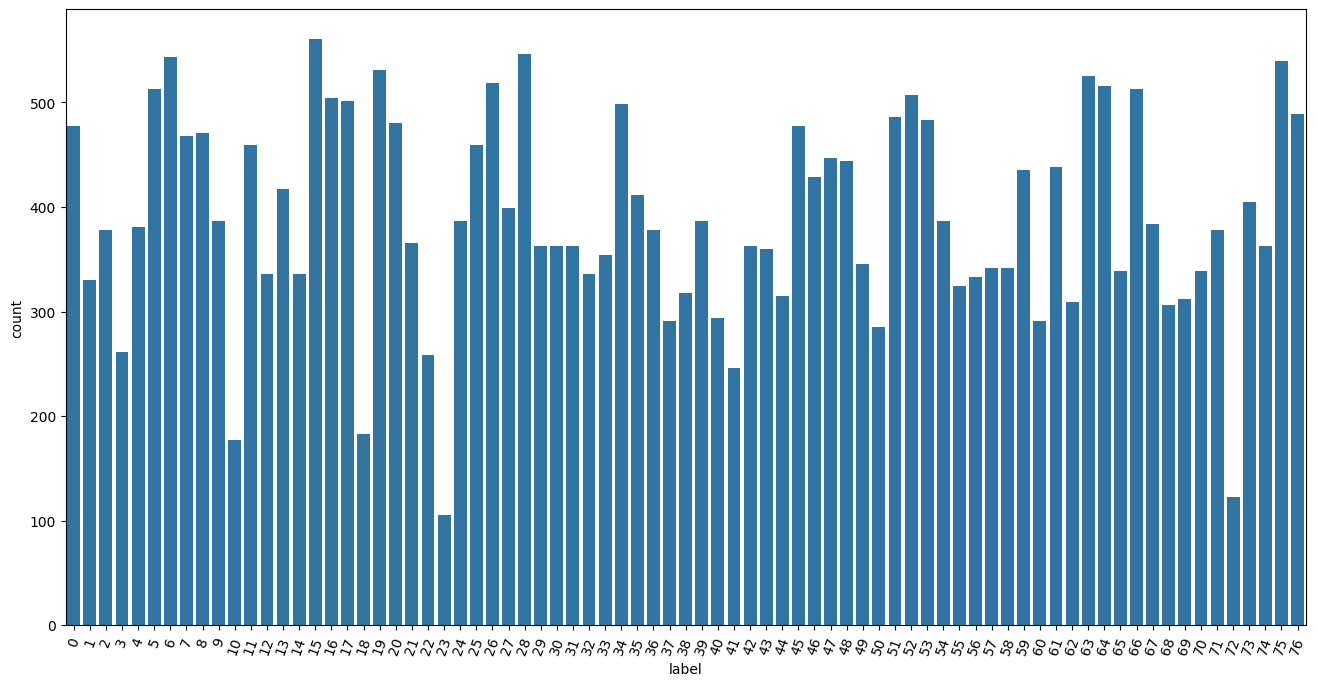

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.xticks(rotation=70)
sns.countplot(x='label', data=df_flattened)
plt.show()

Observation:

Classes are highly imbalanced

In [ ]:
# check total number of labels
df_flattened.duplicated().sum()
print(len(df_flattened['label'].value_counts()))

77


In [ ]:
# check for null Valious
df_flattened.isnull().values.any()

False

In [13]:
print(f'Text = {df_flattened["text"][5000]}, Intent = {df_flattened["label"][5000]}')

Text = Is it right that I've been charged for transferring money?, Intent = 64


In [14]:
df_train_aug = df_flattened.copy()

**Preprocess data**

- Code here can be re-used in production

In [15]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def clean_text(text: str) -> str:
    """
    Clean text data by removing punctuation, stopwords, \
           and converting to lowercase.
    Args: text (str): Input text from the user to be cleaned.
    Returns (str): cleaned text
    """
    tokens = re.sub(r"\{\{.*?\}\}", "", text)
    tokens = word_tokenize(tokens)
    tokens = [w.lower() for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df_train_aug['text'] = df_train_aug['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

print(df_train_aug['text'][13031])


purchased something abroad incorrect rate exchange applied


In [16]:
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

def nltk_to_wordnet_pos(nltk_tag: str) -> str:
    """
    Converts an NLTK POS (part-of-speech) tag to a
    corresponding WordNet POS tag.
    This conversion is useful for lemmatization tasks where WordNet requires 
    specific POS tags.
    Args:
        nltk_tag (str): The POS tag generated by NLTK's `pos_tag` function.
    Returns:
        str or None: The corresponding WordNet POS tag (`wordnet.ADJ`,
                     `wordnet.VERB`, `wordnet.NOUN`, `wordnet.ADV`), or `None`
                     if the NLTK tag does not correspond to any of these.
    """
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatizer(data: str) -> list[str]:
    """
    Lemmatizes the input text data by converting words to their base
    or dictionary form using NLTK's WordNetLemmatizer.
    The function first tokenizes the input text, assigns 
    part-of-speech (POS) tags, and then lemmatizes each word 
    based on its POS tag.

    Args:
        data (str): The input text to be lemmatized.

    Returns:
        list: A list of lemmatized words from the input text.
    """
    wordnet_lem = WordNetLemmatizer()
    tokens = word_tokenize(data)
    pos_tags = pos_tag(tokens)

    lemmatized_words = []
    for word, tag in pos_tags:
        wn_tag = nltk_to_wordnet_pos(tag)
        if wn_tag is None:
            lemmatized_word = wordnet_lem.lemmatize(word)
        else:
            lemmatized_word = wordnet_lem.lemmatize(word, pos=wn_tag)
        lemmatized_words.append(lemmatized_word)

    return lemmatized_words

df_train_aug_clean = df_train_aug.copy()
df_test_clean = df_test.copy()

df_train_aug_clean['text'] = df_train_aug_clean['text'].apply(lambda x: lemmatizer(x))
df_test_clean['text'] = df_test_clean['text'].apply(lambda x: lemmatizer(x))

**Calculating Sequence lengths**

1. Efficient padding
2. Computational Efficiency
3. Memory management
4. Data insights 

In [17]:
def calculate_average_length(data: list[str]) -> float:
    """
    Calculate the average length of sequences (strings) in the provided list.
    Args:
        data (list[str]): A list of strings, where each string represents a sequence.
    Returns:
        float: The average length of the sequences in the list.
    """
    total_length = 0
    total_sequences = len(data)

    for seq in data:
        total_length += len(seq)

    average_length = total_length / total_sequences
    return average_length

average_length = calculate_average_length(df_train_aug_clean['text'])
print("Average length of sequences:", average_length)

Average length of sequences: 5.6816954913525946


Average sequence length: 5.68
Maximum sequence length: 49
Minimum sequence length: 0


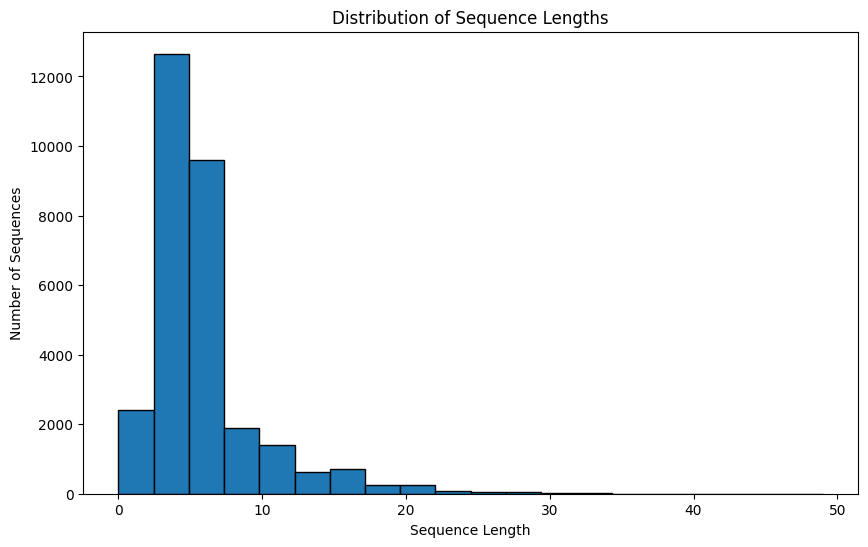

{1: 194, 4: 6468, 5: 4731, 7: 1845, 12: 393, 10: 556, 3: 6187, 13: 339, 9: 763, 2: 2206, 6: 3010, 15: 309, 11: 445, 16: 220, 18: 138, 14: 297, 8: 1121, 19: 124, 20: 118, 27: 14, 23: 46, 22: 63, 17: 196, 30: 13, 26: 28, 21: 81, 25: 21, 24: 23, 28: 15, 29: 14, 33: 5, 34: 3, 37: 2, 32: 2, 39: 1, 31: 7, 35: 1, 49: 1, 0: 2, 45: 1, 38: 1, 36: 2, 41: 1, 46: 1, 44: 1}


In [18]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def calculate_statistics(sequences: list[str]):
    """
    Calculate the average, maximum, and minimum lengths of the sequences.
    Args:
        sequences (list[str]): List of text sequences.
    Returns:
        tuple: Average length, maximum length, minimum length of the sequences.
    """
    total_length = sum(len(seq) for seq in sequences)
    total_sequences = len(sequences)
    average_length = total_length / total_sequences
    max_length = max(len(seq) for seq in sequences)
    min_length = min(len(seq) for seq in sequences)
    return average_length, max_length, min_length


def plot_sequence_length_distribution(sequences: list[str], bins: int=20):
    """
    Plot the distribution of sequence lengths in a histogram.
    Args:
        sequences (list[str]): List of text sequences.
        bins (int, optional): Number of bins for the histogram. Default is 20.
    """
    plt.figure(figsize=(10, 6))
    plt.hist([len(seq) for seq in sequences], bins=bins, edgecolor='black')
    plt.xlabel("Sequence Length")
    plt.ylabel("Number of Sequences")
    plt.title("Distribution of Sequence Lengths")
    plt.show()


def count_sequence_length_frequencies(sequences: list[str]) -> dict[int, int]:
    """
    Count the frequency of each sequence length.
    Args:
        sequences (list[str]): List of text sequences.
    Returns:
        dict dict[int, int]: A dictionary where keys are sequence 
                             lengths and values are their frequencies.
    """
    sequence_length_dict = {}
    for seq in sequences:
        length = len(seq)
        sequence_length_dict[length] = sequence_length_dict.get(length, 0) + 1
    return sequence_length_dict


# Main execution code
sequences = df_train_aug_clean['text']

# Calculate statistics
average_length, max_length, min_length = calculate_statistics(sequences)
print(f"Average sequence length: {average_length:.2f}")
print(f"Maximum sequence length: {max_length}")
print(f"Minimum sequence length: {min_length}")

# Plot distribution of sequence lengths
plot_sequence_length_distribution(sequences)

# Count and print sequence length frequencies
sequence_length_dict = count_sequence_length_frequencies(sequences)
print(sequence_length_dict)


Observation:

- Left skewed distribution
- There are 2 sequences with 0 length (Need to be filtered out)


In [ ]:
filtered_data = df_train_aug_clean[df_train_aug_clean['text'].apply(len) > 0] \
                                                            .reset_index(drop=True)  # Reset index for alignment

print("Original customer_data:")
print(df_train_aug_clean.shape)

print("\nFiltered data:")
print(filtered_data.shape)

Original customer_data:
(30009, 2)

Filtered data:
(30007, 2)


**Most Common Words**

In [20]:
from collections import Counter
from typing import List, Tuple

def list_tokens(docs: List[str]) -> List[str]:
    """
    Tokenizes a list of documents into individual words.
    Args:
        docs (List[str]): A list of documents where each document is a string.
    Returns:
        List[str]: A list of individual tokens (words) from all documents.
    """
    token_list = []
    for token in docs:
        for word in token:
            token_list.append(word)
    return token_list


def most_common_words(docs: List[str], n: int) -> List[Tuple[str, int]]:
    """
    Identifies the most common words in a list of documents.
    Args:
        docs (List[str]): A list of documents where each document is a string.
        n (int): The number of most common words to return.
    Returns:
        List[Tuple[str, int]]: A list of tuples where each tuple contains a 
        word and its frequency, ordered by the most common words.
    """
    counter = Counter(list_tokens(docs))
    common_words = counter.most_common(n)
    return common_words

common_words = most_common_words(filtered_data['text'], 10)
common_words

[('card', 7976),
 ('transfer', 3685),
 ('account', 3623),
 ('get', 3518),
 ('money', 3417),
 ('top', 2795),
 ('charge', 2634),
 ('make', 2319),
 ('payment', 2263),
 ('use', 2126)]

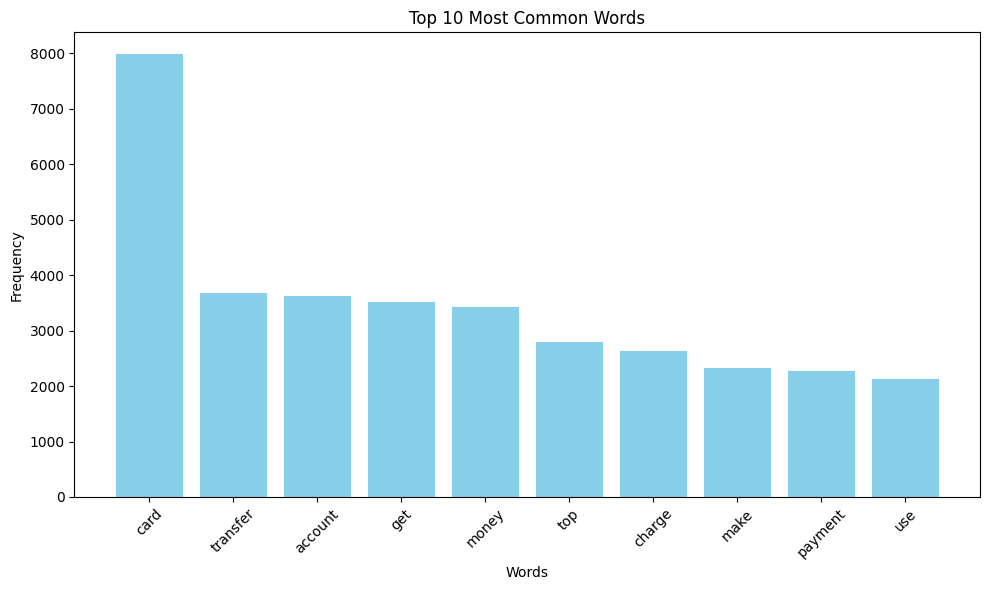

In [21]:
from typing import List, Tuple
import matplotlib.pyplot as plt

def plot_common_words(common_words: List[Tuple[str, int]]) -> None:
    """
    Plots a bar chart of the most common words and their frequencies.

    Args:
        common_words (List[Tuple[str, int]]): A list of tuples where each 
        tuple contains a word and its frequency. The list is typically 
        generated from a word frequency counter.
    """
    plt.figure(figsize=(10, 6))
    words, frequencies = zip(*common_words)  # Unzips the list of tuples
    plt.bar(words, frequencies, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {len(common_words)} Most Common Words')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

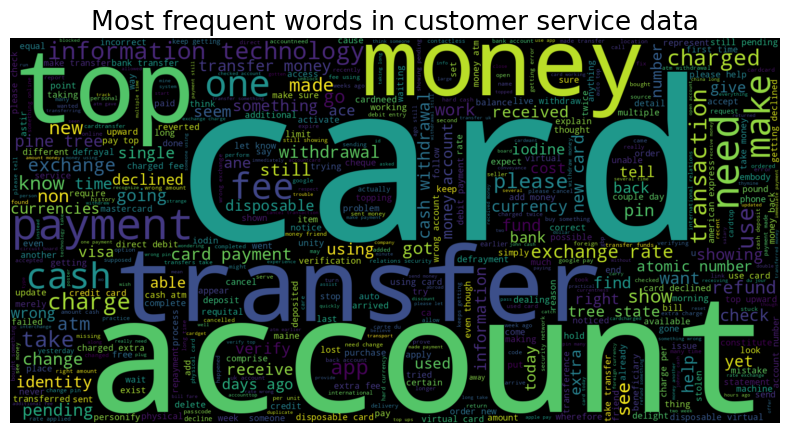

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

def generate_word_cloud(text_data: pd.Series, 
                        title: str = "Most frequent words in customer service data") -> None:
    """
    Generates and displays a word cloud based on the input text data.
    Args:
        text_data (pd.Series): A pandas Series containing the text data to generate the word cloud from.
        title (str): The title for the word cloud plot. Defaults to "Most frequent words in customer service data".
    Returns:
        None: This function only displays the word cloud and does not return any values.
    """
    # Combine all text into a single string
    text = ''.join([word for word in text_data])
    
    # Generate the word cloud
    plt.figure(figsize=(10, 5), facecolor='None')
    wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
    
    # Display the word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=19)
    plt.show()

In [23]:
df_vocab = pd.concat([filtered_data, df_test_clean], ignore_index=True)

#### 3 Tokenization pipeline

In [24]:
from typing import List, Dict

def vocabulary(data: List[str]) -> Dict[str, int]:
  """
    Creates a vocabulary mapping from a list of tokenized sequences, 
    including special tokens for padding and unknown words.
    Args:
        data (List[str]): A list of tokenized sequences (list of strings).
    Returns:
        Dict[str, int]: A dictionary mapping tokens to their corresponding indices, 
                        including '<PAD>' and '<UNK>' for padding and unknown tokens.
    """
  tokens = sorted(set(token for seq in data for token in seq))
  tokens = ['<PAD>'] + tokens
  tokens = ['<UNK>'] + tokens
  token_to_index = {token: index for index, token in enumerate(tokens)}
  token_to_index['<PAD>'] = 1
  token_to_index['<UNK>'] = 0
  return token_to_index


class Tokenizer:
  """
    A tokenizer class that encodes text into integer tokens based on the provided vocabulary, 
    and decodes integer tokens back into text.
    """
  def __init__(self, vocab: Dict[str, int]):
    self.str_to_int = vocab
    self.int_to_str = {v: k for k, v in vocab.items()}
    

  def encode(self, text: str) -> List[str]:
    """
    Encodes a text string into a list of integers using the vocabulary.
    Args:
        text (str): Input text to be tokenized and encoded.
    Returns:
        List[int]: A list of integers representing the tokenized input text.
    """
    return [self.str_to_int[token] for token in text.split()]
  

  def decode(self, tokens: List[int]) -> str:
    """
    Decodes a list of integer tokens back into a text string.
    Args:
        tokens (List[int]): A list of integers representing encoded tokens.
    Returns:
        str: The decoded text.
    """
    tokens = [tokenizer.int_to_str[token] for token in tokens if token != 0]
    return ' '.join(tokens)
  

vocab = vocabulary(df_vocab['text'])
print("Vocab:", vocab)
print(len(vocab))

text = 'check account'
tokenizer = Tokenizer(vocab)
integers = tokenizer.encode(text)
print('Encoded text:', integers)
print('Decoded text:', tokenizer.decode(integers))

Vocab: {'<UNK>': 0, '<PAD>': 1, 'abide': 2, 'abject': 3, 'able': 4, 'abnegate': 5, 'abode': 6, 'abortive': 7, 'abroad': 8, 'absent': 9, 'absolutely': 10, 'abuse': 11, 'accelerator': 12, 'accept': 13, 'acceptable': 14, 'accepted': 15, 'accepts': 16, 'access': 17, 'accessible': 18, 'accessing': 19, 'accession': 20, 'accident': 21, 'accidentally': 22, 'accidently': 23, 'accommodate': 24, 'accord': 25, 'accordingly': 26, 'account': 27, 'accounting': 28, 'accpeted': 29, 'accredit': 30, 'accumulation': 31, 'accurate': 32, 'accusation': 33, 'accuse': 34, 'ace': 35, 'achieve': 36, 'acknowledge': 37, 'acknowledgment': 38, 'acme': 39, 'acount': 40, 'acquaintance': 41, 'acquire': 42, 'across': 43, 'act': 44, 'action': 45, 'activate': 46, 'activated': 47, 'activating': 48, 'activation': 49, 'active': 50, 'activity': 51, 'actual': 52, 'actually': 53, 'actuate': 54, 'ad': 55, 'add': 56, 'added': 57, 'addition': 58, 'additional': 59, 'additionally': 60, 'address': 61, 'adequate': 62, 'adjacent': 63, 

**Numericalize & Padding**

In [25]:
import torch
from torch.nn.utils.rnn import pad_sequence
from typing import List, Dict, Union

def numericalize(vocab: Dict[str, int], 
                 data: Union[List[str], List[List[str]]]) -> List[List[int]]:
    """
    Converts tokens into their corresponding numerical indices
    based on a given vocabulary. If a token is not found in the vocabulary,
    a special '<UNK>' token is used.
    Args:
        vocab (dict): A dictionary mapping tokens (words) to their
                      corresponding numerical indices.
        data (Union[List[str], List[List[str]]]): 
                     A list of tokens (words) to be converted into numerical
                     indices.
    Returns:
        List[List[int]]: A list containing a list of numerical indices 
                        representing the input text data.
    """
    indexed_data = []

    if isinstance(data[0], list):
        # If input is a list of tokenized documents
        for seq in data:
            indexed_seq = [vocab.get(token, vocab['<UNK>']) for token in seq]
            indexed_data.append(indexed_seq)
    else:
        # If input is a single tokenized document
        indexed_seq = [vocab.get(token, vocab['<UNK>']) for token in data]
        indexed_data.append(indexed_seq)

    return indexed_data


def pad_documents(vocab: Dict[str, int], data: List[List[str]], max_length: int) -> torch.Tensor:
    """
    Pads a list of tokenized documents to a fixed maximum length and converts them 
    into a tensor. Sequences are reversed before padding, and then reversed back.
    Args:
        vocab (Dict[str, int]): A dictionary mapping tokens to indices, including special tokens.
        data (List[List[str]]): A list of tokenized documents (list of tokens) to be padded.
        max_length (int): The maximum length to pad/truncate the sequences.
    Returns:
        torch.Tensor: A tensor of padded sequences with shape (batch_size, max_length).
    """
    indexed_data = numericalize(vocab, data)
    max_length = int(max_length)

    reversed_seqs = [torch.flip(torch.tensor(seq, dtype=torch.long), dims=[0]) for seq in indexed_data]
    padded_docs = pad_sequence([seq[:max_length] for seq in reversed_seqs],
                                batch_first=True, padding_value=vocab['<PAD>'])
    padded_docs = torch.flip(padded_docs, dims=[1])

    return padded_docs

average_length = calculate_average_length(filtered_data['text'])


In [26]:
padded_docs_train = pad_documents(vocab, filtered_data['text'], 20)
padded_docs_test = pad_documents(vocab, df_test_clean['text'], 20)
print(padded_docs_train[700])
print(len(padded_docs_train[0]))

tensor([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1, 2903, 1454, 2669, 2168,  675,  159, 2442])
20


In [27]:
import torch
import pandas as pd

def transfer_to_device(data, device: torch.device) -> torch.Tensor:
    """
    Transfers the given data (tensor or labels) to the specified device (GPU/CPU).
    Args:
        data (torch.Tensor or pd.Series): The data to transfer (either tensor or labels).
        device (torch.device): The target device ('cuda' or 'cpu').
    Returns:
        torch.Tensor: The data moved to the target device.
    """
    if isinstance(data, pd.Series):
        # Convert pandas Series (labels) to PyTorch tensor
        return torch.tensor(data.values, dtype=torch.long).to(device)
    elif isinstance(data, torch.Tensor):
        # Transfer PyTorch tensor (documents) to device
        return data.to(device)
    else:
        raise ValueError("Data must be either a torch.Tensor or a pandas.Series")


# Detect the available device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Transfer the padded document tensors to the device
padded_docs_train = transfer_to_device(padded_docs_train, device)
padded_docs_test = transfer_to_device(padded_docs_test, device)

# Transfer the labels to the device
labels_train = transfer_to_device(filtered_data['label'], device)
labels_test = transfer_to_device(df_test_clean['label'], device)


#### 4. Dataset creation + Class Imbalance Handling + Embedding Matrix

**Create Training and Testing Datasets**

In [28]:
from torch.utils.data import Dataset, DataLoader, random_split, default_collate

class BankingDataset(Dataset):
    """
    Custom PyTorch Dataset for the banking intent classification task.
    This dataset holds padded document sequences (features) and their 
    corresponding labels.

    Args:
        X (list or np.array or torch.Tensor): The input features (padded document sequences).
        y (list or np.array or torch.Tensor): The target labels for the classification task.
    """
    
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __iter__(self):
        return iter(self.X)

    def __len__(self):
        """
          Returns the length of the dataset (number of samples).
          
          Returns:
              int: The number of samples in the dataset.
          """
        return len(self.X)

    def __getitem__(self, idx):
        """
          Retrieves a sample (features and label) from the dataset at the given index.
          Args:
              idx (int): Index of the sample to retrieve.
          Returns:
              tuple: A tuple containing the features and the corresponding label for the sample.
          """
        features = self.X[idx]
        labels = self.y[idx]
        return features, labels

trainset = BankingDataset(padded_docs_train, labels_train)
testset = BankingDataset(padded_docs_test, labels_test)

<ipython-input-28-54e2bd7c5caf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.long)
<ipython-input-28-54e2bd7c5caf>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)


**Handling Class Imbalance**

In [29]:
from collections import Counter

def get_class_weights(data: List[str]) -> torch.Tensor:
    """
      Compute class weights based on the distribution of classes in the dataset.
      This is useful to handle class imbalance by assigning higher weights to 
      underrepresented classes, which can be used during training to give these 
      classes more importance.
      Args:
          data (List[str]): A list of class labels from the dataset, where each
                            label corresponds to a sample.
      Returns:
          torch.Tensor: A tensor containing the calculated class weights. The size of the 
                        tensor corresponds to the number of unique classes in the dataset.
      """
    class_counts = Counter(data)
    total_samples = sum(class_counts.values())
    class_weights = [total_samples / (len(class_counts) * count) for count in class_counts.values()]
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    return class_weights_tensor

class_weights = get_class_weights(filtered_data['label'])
class_weights = class_weights.to(device)
print(class_weights)

tensor([0.7825, 0.8119, 1.5842, 0.6947, 0.7217, 0.9482, 0.7597, 1.0148, 1.4931,
        1.0825, 0.9767, 1.0070, 1.2255, 1.0070, 1.0736, 0.7778, 1.1598, 0.8068,
        1.0255, 1.1395, 1.0736, 1.2371, 0.7686, 0.9345, 0.8959, 1.2490, 1.1496,
        0.8490, 1.1598, 0.8327, 0.8897, 0.8777, 0.8170, 1.1598, 0.9084, 2.1295,
        0.7137, 1.0736, 1.0070, 1.0648, 3.1683, 0.7339, 1.1296, 1.3255, 0.7177,
        0.7732, 1.0310, 1.0736, 0.8490, 1.0736, 0.8170, 1.0070, 0.9622, 1.1496,
        1.3392, 0.8718, 1.0310, 0.7969, 1.3674, 1.2028, 2.2017, 1.2735, 1.3438,
        1.2612, 0.7423, 0.7552, 1.1395, 0.7597, 1.1009, 0.8019, 1.5105, 1.1809,
        1.1703, 0.7509, 1.0310, 3.7114, 0.8274], device='cuda:0')


**Embedding Matrix with GlovE**

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

In [ ]:
!cp -r glove.6B.zip /content/drive/MyDrive/Embeddings\ data
# unzip the data in google drive

In [30]:
!unzip /content/drive/MyDrive/Embeddings\ data/glove.6B.zip

Archive:  /content/drive/MyDrive/Embeddings data/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [31]:
import numpy as np
from typing import Dict

def load_glove_embeddings(glove_path: str) -> Dict[str, np.ndarray]:
    """
    Load pre-trained GloVe embeddings from a file and return them as a dictionary.
    Args:
        glove_path (str): The file path to the pre-trained GloVe embeddings.
    Returns:
        Dict[str, np.ndarray]: A dictionary where the keys are words and the values are 
                               the corresponding GloVe vectors as numpy arrays.
    """
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    return embeddings_index


def create_embedding_matrix(vocab: Dict[str, int], glove_embeddings: Dict[str, np.ndarray]) -> np.ndarray:
    """
    Creates an embedding matrix using the provided vocabulary and GloVe embeddings.
    Args:
        vocab (Dict[str, int]): A dictionary mapping words to their corresponding indices.
        glove_embeddings (Dict[str, np.ndarray]): A dictionary of pre-trained GloVe embeddings.
    Returns:
        np.ndarray: An embedding matrix of shape (vocab_size, embedding_dim).
    """
    embedding_dim = len(next(iter(glove_embeddings.values())))  # Get the dimension from the first entry
    vocab_size = len(vocab) + 1  # Add 1 for padding token (if necessary)

    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in vocab.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]

    return embedding_matrix

embedding_matrix = create_embedding_matrix(vocab, 'glove.6B.50d.txt')
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [32]:
embedding_matrix.to(device)
embedding_matrix.shape
print(embedding_matrix)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.7481, -0.4480, -0.5124,  ...,  1.0560, -0.5281, -0.1355],
        ...,
        [-0.0668,  0.5760, -0.1733,  ..., -0.3754,  0.0666, -0.1422],
        [-0.0052,  0.4748,  0.8903,  ...,  0.2017,  0.4701,  0.4411],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [33]:
def cosine_similarity_word(word1, word2, model_type, embedding_model):
    """
    Calculates the cosine similarity between two words using either Word2Vec or GloVe embeddings.
    Args:
        word1: The first word.
        word2: The second word.
        model_type: Type of the embedding model ('word2vec' or 'glove').
        embedding_model: The embedding model (Word2Vec model or embedding matrix).

    Returns:
        The cosine similarity between the two words.
    """
    if model_type == 'word2vec':
        vec1 = embedding_model.wv[word1]
        vec2 = embedding_model.wv[word2]
    elif model_type == 'glove':
        vec1 = embedding_model[vocab[word1]]
        vec2 = embedding_model[vocab[word2]]

    similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return similarity

In [34]:
similarity_score_glove = cosine_similarity_word("cash", "money", "glove", embedding_matrix)
print("Cosine similarity between 'cash' and 'money' (GloVe):", similarity_score_glove)

Cosine similarity between 'cash' and 'money' (GloVe): 0.898987


#### 4. Modelling

In [53]:
embedding_dim = embedding_matrix.shape[1]
embedding_weights = embedding_matrix
input_size = embedding_weights.size(1)
print(embedding_weights.size(1))
torch.manual_seed(42)

config = {"embedding_weights": embedding_weights,
          "input_size": embedding_weights.size(1),
          "num_layers": 2,
          "num_labels":77,
          "hidden_size": 300,
          "dropout_lstm": 0.10,
          "dropout_linear": 0.20,
          }

50


In [54]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class IntentClassifier(nn.Module):
    """
      A Bidirectional LSTM-based classifier for intent detection. This model 
      consists of an embedding layer, a bidirectional LSTM, and multiple 
      linear layers with GELU activation functions and dropout for 
      regularization.

      Args:
          config (dict): Configuration dictionary containing model parameters 
          such as:
              - 'input_size' (int): Size of the input feature vector.
              - 'hidden_size' (int): # of features in the LSTM's hidden state.
              - 'num_layers' (int): # of recurrent layers in the LSTM.
              - 'dropout_lstm' (float): Dropout for the LSTM layers.
              - 'dropout_linear' (float): Dropout for the linear layers.
              - 'num_labels' (int): # of output classes for the classification.
      """
    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding.from_pretrained(config['embedding_weights'], freeze=True)

        self.bi_lstm = nn.LSTM(config['input_size'], config['hidden_size'],
                             config['num_layers'], dropout=config['dropout_lstm'],
                             batch_first=True, bidirectional=True)

        self.dropout_bilstm = nn.Dropout(p=config['dropout_lstm'])
        self.act1 = nn.GELU()

        self.linear1 = nn.Linear(config['hidden_size'] * 2, config['hidden_size'] - 100)
        self.norm1 = nn.LayerNorm(config['hidden_size'] - 100)
        self.dropout_linear1 = nn.Dropout(p=config['dropout_linear'])
        self.act_lin1 = nn.GELU()

        self.linear2 = nn.Linear(config['hidden_size'] - 100, config['hidden_size'] // 2)
        self.norm2 = nn.LayerNorm(config['hidden_size'] // 2)
        self.dropout_linear2 = nn.Dropout(p=config['dropout_linear'])
        self.act_lin2 = nn.GELU()

        self.output = nn.Linear(config['hidden_size'] // 2, config['num_labels'])

        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'lstm' in name:
                    init.xavier_uniform_(param)
                elif 'linear' in name:
                    init.xavier_normal_(param)


    def forward(self, x, h0=None, c0=None):
        """
          Forward pass of the model. Processes the input through the embedding 
          layer, bidirectional LSTM, and a series of linear layers to 
          produce class scores.
          Args:
              x (torch.Tensor): Input tensor of shape (batch_size, seq_length).
              h0 (torch.Tensor, optional): Initial hidden state for the LSTM. 
                  Defaults to None, which initializes it as zeros.
              c0 (torch.Tensor, optional): Initial cell state for the LSTM. 
                  Defaults to None, which initializes it as zeros.
          Returns:
              torch.Tensor: Output tensor of shape (batch_size, num_labels) 
              containing the class scores for each input sequence in the batch.
        """
        if h0 is None:
            h0 = torch.zeros(self.config['num_layers'] * 2, x.size(0), self.config['hidden_size']).to(x.device)
        if c0 is None:
            c0 = torch.zeros(self.config['num_layers'] * 2, x.size(0), self.config['hidden_size']).to(x.device)

        x = self.embedding(x)

        x, _ = self.bi_lstm(x, (h0, c0))
        x = self.act1(self.dropout_bilstm(x))

        x = self.linear1(x[:, -1, :])
        x = self.norm1(x)
        x = self.act_lin1(self.dropout_linear1(x))

        x = self.linear2(x)
        x = self.norm2(x)
        x = self.act_lin2(self.dropout_linear2(x))

        x = self.output(x)

        return x

model = IntentClassifier(config)

print(model)
print('Number of parameters', sum(p.numel() for p in model.parameters()))

IntentClassifier(
  (embedding): Embedding(3830, 50)
  (bi_lstm): LSTM(50, 300, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (dropout_bilstm): Dropout(p=0.1, inplace=False)
  (act1): GELU(approximate='none')
  (linear1): Linear(in_features=600, out_features=200, bias=True)
  (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
  (dropout_linear1): Dropout(p=0.2, inplace=False)
  (act_lin1): GELU(approximate='none')
  (linear2): Linear(in_features=200, out_features=150, bias=True)
  (norm2): LayerNorm((150,), eps=1e-05, elementwise_affine=True)
  (dropout_linear2): Dropout(p=0.2, inplace=False)
  (act_lin2): GELU(approximate='none')
  (output): Linear(in_features=150, out_features=77, bias=True)
)
Number of parameters 3363777


In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

metric = 'accuracy'
patience = 10

# Hyperparameters
n_epochs = 100
batch_size = 256
learning_rate = 0.0003
weight_decay = 1e-3
l1_lambda = 0.0001

# Load model unto device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = IntentClassifier(config)
model.to(device)

# Model, optimizer, scheduler, and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)
loss_fn = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Data Loaders
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)


In [56]:
import copy
from typing import Tuple
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

def train(model: nn.Module, 
          train_loader: DataLoader, 
          optimizer: torch.optim.Optimizer, 
          loss_fn: nn.Module,
          l1_lambda: float = 0.0001) -> Tuple[float, float]:
  
    """
    Train the model for one epoch on the given dataset.
    Args:
        model (nn.Module): The neural network model to be trained.
        train_loader (DataLoader): DataLoader providing the training data.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        loss_fn (nn.Module): Loss function used for training.
        l1_lambda (float, optional): Regularization factor for L1 loss. Default is 0.0001.
    Returns:
        Tuple[float, float]: The average loss and accuracy for the epoch.
    """
  
    model.train()
    epoch_loss = []
    epoch_acc = []

    with tqdm(train_loader, unit='batch', mininterval=0, disable=False) as bar:
        for X_batch, y_batch in bar:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            l1_reg_loss = 0
            for param in model.parameters():
                l1_reg_loss += torch.norm(param, p=1)
            loss += l1_lambda * l1_reg_loss

            loss.backward()
            optimizer.step()

            pred_labels = torch.argmax(y_pred, dim=1)
            correct = (pred_labels == y_batch).sum().item()
            acc = correct / len(y_batch)
            epoch_loss.append(loss.item())
            epoch_acc.append(acc)

            # # Update progress bar
            # bar.set_postfix(loss=float(loss), acc=float(acc))

    return np.mean(epoch_loss), np.mean(epoch_acc)
  

def evaluate(model: nn.Module, 
             test_loader: DataLoader, 
             loss_fn: nn.Module) -> Tuple[float, float]:
    """
    Evaluate the model on the test dataset.
    Args:
        model (nn.Module): The neural network model to be evaluated.
        test_loader (DataLoader): DataLoader providing the test data.
        loss_fn (nn.Module): Loss function used for evaluation.
    Returns:
        Tuple[float, float]: The average loss and accuracy for the test dataset.
    """
    model.eval()
    loss_list = []
    acc_list = []

    with torch.no_grad():
      for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)
        loss_list.append(loss.item())

        _, predicted = torch.max(y_pred, 1)
        correct = (predicted == y_batch).sum().item()
        acc = correct / len(y_batch)
        acc_list.append(acc)

    return np.mean(loss_list), np.mean(acc_list)


import copy
from typing import Tuple

def early_stopping(
    val_metric_min: float, 
    val_metric: float, 
    model: torch.nn.Module, 
    patience: int, 
    metric: str, 
    epoch: int, 
    best_epoch: int, 
    best_weights: dict, 
    no_improvement: int, 
    stop_training: bool
) -> Tuple[float, dict, int, bool, int]:
    """
    Implements early stopping during training to prevent overfitting by monitoring the
    validation metric (either loss or accuracy).
    Args:
        val_metric_min (float): The best recorded validation metric (either minimum loss or maximum accuracy).
        val_metric (float): The current validation metric value.
        model (torch.nn.Module): The model being trained.
        patience (int): Number of epochs to wait before stopping if no improvement.
        metric (str): The metric being tracked ('loss' or 'accuracy').
        epoch (int): The current epoch number.
        best_epoch (int): The epoch where the best metric was recorded.
        best_weights (dict): The model weights when the best metric was achieved.
        no_improvement (int): Counter for epochs without improvement.
        stop_training (bool): Flag indicating whether to stop training.
    Returns:
        Tuple[float, dict, int, bool, int]: 
            - Updated best validation metric.
            - Updated best model weights.
            - Updated no_improvement counter.
            - Updated stop_training flag.
            - Updated best_epoch number.
    """
    is_improvement = (
        (metric == 'loss' and val_metric < val_metric_min) or
        (metric == 'accuracy' and val_metric > val_metric_min)
    )

    if is_improvement:
        # Improvement found, update the best metric and reset the counter
        val_metric_min = val_metric
        best_weights = copy.deepcopy(model.state_dict())
        best_epoch = epoch + 1
        no_improvement = 0
        stop_training = False
        print(f"New best {metric}: {val_metric_min:.4f} at epoch {best_epoch}")
    else:
        # No improvement, increment counter
        no_improvement += 1
        if no_improvement >= patience:
            stop_training = True
            print(f"Early stopping at epoch {epoch + 1}")

    return val_metric_min, best_weights, no_improvement, stop_training, best_epoch
  

def train_and_evaluate(
    model: torch.nn.Module, 
    train_loader: torch.utils.data.DataLoader, 
    test_loader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer, 
    loss_fn: torch.nn.Module, 
    n_epochs: int, 
    metric: str, 
    patience: int, 
    scheduler: torch.optim.lr_scheduler._LRScheduler
) -> Tuple[Dict[str, List[float]], Dict[str, List[float]], Dict[str, float]]:
    """
    Trains and evaluates the model using the specified metric, tracks learning
    progress, and implements early stopping.

    Args:
        model (torch.nn.Module): The PyTorch model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        test_loader (torch.utils.data.DataLoader): DataLoader for the validation/test dataset.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        loss_fn (torch.nn.Module): Loss function.
        n_epochs (int): Number of training epochs.
        metric (str): The metric to track ('loss' or 'accuracy').
        patience (int): Early stopping patience.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.

    Returns:
        Tuple[Dict[str, List[float]], Dict[str, List[float]], Dict[str, float]]:
            - History of training and validation loss/accuracy.
            - Final best weights after early stopping.
            - Best validation metric.
    """
    # Initialize tracking variables
    best_weights = None
    train_metrics = {"loss": [], "accuracy": []}
    val_metrics = {"loss": [], "accuracy": []}
    val_metric_min = np.inf if metric == 'loss' else -np.inf
    best_epoch = -1
    no_improvement = 0
    stop_training = False

    # Training loop
    for epoch in range(n_epochs):
        current_lr = optimizer.param_groups[0]['lr']

        # Training step
        train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
        train_metrics["loss"].append(train_loss)
        train_metrics["accuracy"].append(train_acc)

        # Validation step
        val_loss, val_acc = evaluate(model, test_loader, loss_fn)
        val_metrics["loss"].append(val_loss)
        val_metrics["accuracy"].append(val_acc)

        # Determine metric to use for early stopping
        val_metric = val_loss if metric == 'loss' else val_acc

        # Early stopping check
        val_metric_min, best_weights, no_improvement, stop_training, best_epoch = early_stopping(
            val_metric_min, val_metric, model, patience, metric, epoch, 
            best_epoch, best_weights, no_improvement, stop_training
        )

        # Logging progress
        print(f'Epoch {epoch + 1}: '
              f'train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, '
              f'val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, '
              f'lr={current_lr:.6f}')

        # Scheduler step based on validation loss
        scheduler.step(metrics=val_loss)

        # Break if early stopping is triggered
        if stop_training:
            break

    return best_weights, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist

best_weights, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_and_evaluate(
    model,
    train_loader,
    test_loader,
    optimizer,
    loss_fn,
    n_epochs,
    metric,
    patience,
    scheduler
)


100%|██████████| 118/118 [00:04<00:00, 24.43batch/s]


New best accuracy: 0.3591 at epoch 1
Epoch 1 train_loss=19.0816, train_acc=0.1247, val_loss=3.0823, val_acc=0.3591, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.84batch/s]


New best accuracy: 0.5364 at epoch 2
Epoch 2 train_loss=14.1656, train_acc=0.3706, val_loss=2.3270, val_acc=0.5364, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.72batch/s]


New best accuracy: 0.6391 at epoch 3
Epoch 3 train_loss=13.0204, train_acc=0.4974, val_loss=1.9673, val_acc=0.6391, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.73batch/s]


New best accuracy: 0.7025 at epoch 4
Epoch 4 train_loss=12.5738, train_acc=0.5596, val_loss=1.7617, val_acc=0.7025, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.71batch/s]


New best accuracy: 0.7058 at epoch 5
Epoch 5 train_loss=12.2952, train_acc=0.5983, val_loss=1.6967, val_acc=0.7058, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.81batch/s]


New best accuracy: 0.7350 at epoch 6
Epoch 6 train_loss=12.1084, train_acc=0.6188, val_loss=1.6225, val_acc=0.7350, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.83batch/s]


New best accuracy: 0.7563 at epoch 7
Epoch 7 train_loss=11.9517, train_acc=0.6414, val_loss=1.5609, val_acc=0.7563, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.87batch/s]


Epoch 8 train_loss=11.8382, train_acc=0.6585, val_loss=1.5606, val_acc=0.7491, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.88batch/s]


New best accuracy: 0.7692 at epoch 9
Epoch 9 train_loss=11.7469, train_acc=0.6660, val_loss=1.5177, val_acc=0.7692, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.88batch/s]


New best accuracy: 0.7776 at epoch 10
Epoch 10 train_loss=11.6628, train_acc=0.6810, val_loss=1.4878, val_acc=0.7776, lr=0.0003


100%|██████████| 118/118 [00:05<00:00, 22.91batch/s]


New best accuracy: 0.7855 at epoch 11
Epoch 11 train_loss=11.5936, train_acc=0.6906, val_loss=1.4805, val_acc=0.7855, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.79batch/s]


Epoch 12 train_loss=11.5361, train_acc=0.7002, val_loss=1.4859, val_acc=0.7770, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.86batch/s]


New best accuracy: 0.7870 at epoch 13
Epoch 13 train_loss=11.4797, train_acc=0.7070, val_loss=1.4588, val_acc=0.7870, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.98batch/s]


New best accuracy: 0.8008 at epoch 14
Epoch 14 train_loss=11.4269, train_acc=0.7139, val_loss=1.4324, val_acc=0.8008, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.79batch/s]


Epoch 15 train_loss=11.3858, train_acc=0.7207, val_loss=1.4317, val_acc=0.7927, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.87batch/s]


Epoch 16 train_loss=11.3454, train_acc=0.7257, val_loss=1.4203, val_acc=0.7996, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.84batch/s]


New best accuracy: 0.8038 at epoch 17
Epoch 17 train_loss=11.3059, train_acc=0.7327, val_loss=1.4028, val_acc=0.8038, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.84batch/s]


New best accuracy: 0.8089 at epoch 18
Epoch 18 train_loss=11.2711, train_acc=0.7371, val_loss=1.3949, val_acc=0.8089, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.75batch/s]


Epoch 19 train_loss=11.2440, train_acc=0.7433, val_loss=1.3898, val_acc=0.8062, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.76batch/s]


New best accuracy: 0.8131 at epoch 20
Epoch 20 train_loss=11.2120, train_acc=0.7453, val_loss=1.3736, val_acc=0.8131, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.82batch/s]


New best accuracy: 0.8161 at epoch 21
Epoch 21 train_loss=11.1884, train_acc=0.7505, val_loss=1.3719, val_acc=0.8161, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.78batch/s]


Epoch 22 train_loss=11.1589, train_acc=0.7557, val_loss=1.3767, val_acc=0.8101, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.85batch/s]


New best accuracy: 0.8170 at epoch 23
Epoch 23 train_loss=11.1415, train_acc=0.7599, val_loss=1.3639, val_acc=0.8170, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.77batch/s]


New best accuracy: 0.8311 at epoch 24
Epoch 24 train_loss=11.1171, train_acc=0.7627, val_loss=1.3500, val_acc=0.8311, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.77batch/s]


Epoch 25 train_loss=11.0943, train_acc=0.7657, val_loss=1.3472, val_acc=0.8167, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.78batch/s]


New best accuracy: 0.8377 at epoch 26
Epoch 26 train_loss=11.0739, train_acc=0.7718, val_loss=1.3316, val_acc=0.8377, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.81batch/s]


Epoch 27 train_loss=11.0505, train_acc=0.7759, val_loss=1.3332, val_acc=0.8329, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.87batch/s]


Epoch 28 train_loss=11.0296, train_acc=0.7793, val_loss=1.3557, val_acc=0.8242, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.77batch/s]


Epoch 29 train_loss=11.0280, train_acc=0.7786, val_loss=1.3359, val_acc=0.8239, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.80batch/s]


Epoch 30 train_loss=11.0083, train_acc=0.7826, val_loss=1.3274, val_acc=0.8341, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.77batch/s]


Epoch 31 train_loss=10.9909, train_acc=0.7890, val_loss=1.3264, val_acc=0.8359, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.85batch/s]


Epoch 32 train_loss=10.9780, train_acc=0.7906, val_loss=1.3217, val_acc=0.8371, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.86batch/s]


New best accuracy: 0.8419 at epoch 33
Epoch 33 train_loss=10.9542, train_acc=0.7972, val_loss=1.3071, val_acc=0.8419, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.75batch/s]


Epoch 34 train_loss=10.9477, train_acc=0.7968, val_loss=1.3219, val_acc=0.8230, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.76batch/s]


Epoch 35 train_loss=10.9384, train_acc=0.7973, val_loss=1.3078, val_acc=0.8347, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.87batch/s]


New best accuracy: 0.8492 at epoch 36
Epoch 36 train_loss=10.9246, train_acc=0.7999, val_loss=1.2940, val_acc=0.8492, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.77batch/s]


Epoch 37 train_loss=10.9144, train_acc=0.8013, val_loss=1.3115, val_acc=0.8447, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.81batch/s]


Epoch 38 train_loss=10.9019, train_acc=0.8053, val_loss=1.2995, val_acc=0.8431, lr=0.0003


100%|██████████| 118/118 [00:05<00:00, 22.75batch/s]


Epoch 39 train_loss=10.8923, train_acc=0.8077, val_loss=1.2945, val_acc=0.8477, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.86batch/s]


Epoch 40 train_loss=10.8801, train_acc=0.8118, val_loss=1.2963, val_acc=0.8413, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.86batch/s]


New best accuracy: 0.8516 at epoch 41
Epoch 41 train_loss=10.8743, train_acc=0.8110, val_loss=1.2824, val_acc=0.8516, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.85batch/s]


Epoch 42 train_loss=10.8673, train_acc=0.8113, val_loss=1.2880, val_acc=0.8456, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.78batch/s]


Epoch 43 train_loss=10.8534, train_acc=0.8155, val_loss=1.2862, val_acc=0.8462, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.78batch/s]


Epoch 44 train_loss=10.8519, train_acc=0.8155, val_loss=1.2808, val_acc=0.8495, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.85batch/s]


Epoch 45 train_loss=10.8373, train_acc=0.8180, val_loss=1.2825, val_acc=0.8447, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.85batch/s]


Epoch 46 train_loss=10.8305, train_acc=0.8201, val_loss=1.2754, val_acc=0.8447, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.77batch/s]


Epoch 47 train_loss=10.8280, train_acc=0.8216, val_loss=1.2859, val_acc=0.8444, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.80batch/s]


New best accuracy: 0.8522 at epoch 48
Epoch 48 train_loss=10.8199, train_acc=0.8217, val_loss=1.2808, val_acc=0.8522, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.80batch/s]


Epoch 49 train_loss=10.8048, train_acc=0.8271, val_loss=1.2832, val_acc=0.8438, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.86batch/s]


New best accuracy: 0.8564 at epoch 50
Epoch 50 train_loss=10.7984, train_acc=0.8272, val_loss=1.2728, val_acc=0.8564, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.87batch/s]


Epoch 51 train_loss=10.7981, train_acc=0.8287, val_loss=1.2739, val_acc=0.8471, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.77batch/s]


New best accuracy: 0.8570 at epoch 52
Epoch 52 train_loss=10.7951, train_acc=0.8269, val_loss=1.2612, val_acc=0.8570, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.80batch/s]


Epoch 53 train_loss=10.7882, train_acc=0.8270, val_loss=1.2821, val_acc=0.8444, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.80batch/s]


Epoch 54 train_loss=10.7782, train_acc=0.8355, val_loss=1.2745, val_acc=0.8558, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.91batch/s]


Epoch 55 train_loss=10.7733, train_acc=0.8307, val_loss=1.2668, val_acc=0.8507, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.89batch/s]


Epoch 56 train_loss=10.7662, train_acc=0.8335, val_loss=1.2803, val_acc=0.8522, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.76batch/s]


Epoch 57 train_loss=10.7605, train_acc=0.8380, val_loss=1.2702, val_acc=0.8477, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.83batch/s]


Epoch 58 train_loss=10.7546, train_acc=0.8375, val_loss=1.2621, val_acc=0.8549, lr=0.0003


100%|██████████| 118/118 [00:04<00:00, 24.85batch/s]


New best accuracy: 0.8603 at epoch 59
Epoch 59 train_loss=10.7015, train_acc=0.8534, val_loss=1.2423, val_acc=0.8603, lr=7.5e-05


100%|██████████| 118/118 [00:04<00:00, 24.85batch/s]


New best accuracy: 0.8609 at epoch 60
Epoch 60 train_loss=10.6793, train_acc=0.8595, val_loss=1.2412, val_acc=0.8609, lr=7.5e-05


100%|██████████| 118/118 [00:04<00:00, 24.88batch/s]


New best accuracy: 0.8624 at epoch 61
Epoch 61 train_loss=10.6786, train_acc=0.8597, val_loss=1.2407, val_acc=0.8624, lr=7.5e-05


100%|██████████| 118/118 [00:04<00:00, 24.81batch/s]


Epoch 62 train_loss=10.6736, train_acc=0.8590, val_loss=1.2401, val_acc=0.8597, lr=7.5e-05


100%|██████████| 118/118 [00:04<00:00, 24.89batch/s]


Epoch 63 train_loss=10.6732, train_acc=0.8607, val_loss=1.2437, val_acc=0.8603, lr=7.5e-05


100%|██████████| 118/118 [00:04<00:00, 24.88batch/s]


New best accuracy: 0.8639 at epoch 64
Epoch 64 train_loss=10.6700, train_acc=0.8600, val_loss=1.2401, val_acc=0.8639, lr=7.5e-05


100%|██████████| 118/118 [00:04<00:00, 24.86batch/s]


Epoch 65 train_loss=10.6609, train_acc=0.8632, val_loss=1.2389, val_acc=0.8615, lr=7.5e-05


100%|██████████| 118/118 [00:04<00:00, 24.81batch/s]


Epoch 66 train_loss=10.6622, train_acc=0.8599, val_loss=1.2405, val_acc=0.8627, lr=7.5e-05


100%|██████████| 118/118 [00:05<00:00, 22.86batch/s]


Epoch 67 train_loss=10.6589, train_acc=0.8626, val_loss=1.2456, val_acc=0.8597, lr=7.5e-05


100%|██████████| 118/118 [00:04<00:00, 24.83batch/s]


Epoch 68 train_loss=10.6576, train_acc=0.8610, val_loss=1.2416, val_acc=0.8621, lr=7.5e-05


100%|██████████| 118/118 [00:04<00:00, 24.75batch/s]


Epoch 69 train_loss=10.6587, train_acc=0.8623, val_loss=1.2355, val_acc=0.8624, lr=7.5e-05


100%|██████████| 118/118 [00:04<00:00, 24.83batch/s]


Epoch 70 train_loss=10.6558, train_acc=0.8609, val_loss=1.2366, val_acc=0.8633, lr=7.5e-05


100%|██████████| 118/118 [00:04<00:00, 24.84batch/s]


Epoch 71 train_loss=10.6548, train_acc=0.8621, val_loss=1.2394, val_acc=0.8591, lr=7.5e-05


100%|██████████| 118/118 [00:04<00:00, 24.79batch/s]


Epoch 72 train_loss=10.6542, train_acc=0.8634, val_loss=1.2344, val_acc=0.8591, lr=7.5e-05


100%|██████████| 118/118 [00:04<00:00, 24.85batch/s]


Epoch 73 train_loss=10.6493, train_acc=0.8643, val_loss=1.2419, val_acc=0.8606, lr=7.5e-05


100%|██████████| 118/118 [00:04<00:00, 24.84batch/s]


Early stopping at epoch 74
Epoch 74 train_loss=10.6488, train_acc=0.8630, val_loss=1.2423, val_acc=0.8630, lr=7.5e-05
Best accuracy: 0.8638822115384616 at epoch 64


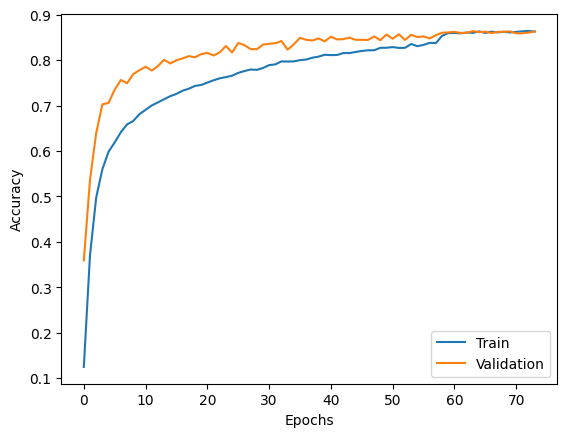

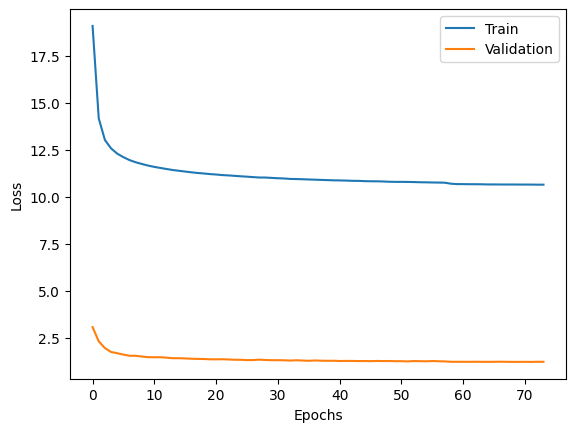

In [57]:
model.load_state_dict(best_weights)

def plot_loss_acc(train_acc, test_acc, train_loss, test_loss):
  """""
  Plot the training and validation accuracy and loss
  """
  plt.plot(train_acc_hist, label='Train')
  plt.plot(val_acc_hist, label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(train_loss_hist, label='Train')
  plt.plot(val_loss_hist, label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

plot_loss_acc(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist)

**Save PyTorch model and Load**

In [58]:
torch.save(model.state_dict(), 'banking-intent-model.pth')

newModel = IntentClassifier(config)
newModel.load_state_dict(torch.load('banking-intent-model.pth'))
newModel.to(device)

IntentClassifier(
  (embedding): Embedding(3830, 50)
  (bi_lstm): LSTM(50, 300, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (dropout_bilstm): Dropout(p=0.1, inplace=False)
  (act1): GELU(approximate='none')
  (linear1): Linear(in_features=600, out_features=200, bias=True)
  (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
  (dropout_linear1): Dropout(p=0.2, inplace=False)
  (act_lin1): GELU(approximate='none')
  (linear2): Linear(in_features=200, out_features=150, bias=True)
  (norm2): LayerNorm((150,), eps=1e-05, elementwise_affine=True)
  (dropout_linear2): Dropout(p=0.2, inplace=False)
  (act_lin2): GELU(approximate='none')
  (output): Linear(in_features=150, out_features=77, bias=True)
)

In [59]:
import torch

torch.save(model.state_dict(), 'model.pth')
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/My Drive/Banking-Intent-Classifier/model.pth'

# Save the model to Google Drive
torch.save(model.state_dict(), model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
from typing import List, Tuple
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report


def evaluate_model(
    model: torch.nn.Module,
    test_loader: DataLoader,
    device: torch.device
) -> Tuple[float, str]:
    """
    Evaluates the model on a given test dataset using accuracy and classification metrics.
    Args:
        model (torch.nn.Module): The PyTorch model to be evaluated.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device): The device to perform the evaluation on (CPU or GPU).
    Returns:
        Tuple[float, str]: Accuracy and classification report as a string.
    """
    model.eval()  # Set the model to evaluation mode
    true_labels: List[int] = []
    predicted_labels: List[int] = []

    with torch.no_grad():  # Disable gradient calculation for faster inference
        for batch in test_loader:
            data, labels = batch
            data, labels = data.to(device), labels.to(device)

            # Model prediction
            y_pred = model(data)

            y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(y_pred)

    # Calculate accuracy and generate the classification report
    accuracy: float = accuracy_score(true_labels, predicted_labels)
    class_report: str = classification_report(true_labels, predicted_labels)

    return accuracy, class_report


test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
accuracy, class_report = evaluate_model(newModel, test_loader, device)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.852922077922078
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        40
           1       0.97      0.95      0.96        40
           2       0.95      0.97      0.96        40
           3       0.97      0.78      0.86        40
           4       0.94      0.80      0.86        40
           5       0.68      0.70      0.69        40
           6       0.92      0.90      0.91        40
           7       0.84      0.80      0.82        40
           8       1.00      0.93      0.96        40
           9       0.97      0.95      0.96        40
          10       0.78      0.72      0.75        40
          11       0.86      0.78      0.82        40
          12       0.79      0.82      0.80        40
          13       0.82      0.93      0.87        40
          14       0.78      0.88      0.82        40
          15       0.71      0.80      0.75        40
          16       0.70      

In [61]:
# Define a dictionary mapping numeric labels to text categories
label_mapping = {
    0: 'activate_my_card',
    1: 'age_limit',
    2: 'apple_pay_or_google_pay',
    3: 'atm_support',
    4: 'automatic_top_up',
    5: 'balance_not_updated_after_bank_transfer',
    6: 'balance_not_updated_after_cheque_or_cash_deposit',
    7: 'beneficiary_not_allowed',
    8: 'cancel_transfer',
    9: 'card_about_to_expire',
    10: 'card_acceptance',
    11: 'card_arrival',
    12: 'card_delivery_estimate',
    13: 'card_linking',
    14: 'card_not_working',
    15: 'card_payment_fee_charged',
    16: 'card_payment_not_recognised',
    17: 'card_payment_wrong_exchange_rate',
    18: 'card_swallowed',
    19: 'cash_withdrawal_charge',
    20: 'cash_withdrawal_not_recognised',
    21: 'change_pin',
    22: 'compromised_card',
    23: 'contactless_not_working',
    24: 'country_support',
    25: 'declined_card_payment',
    26: 'declined_cash_withdrawal',
    27: 'declined_transfer',
    28: 'direct_debit_payment_not_recognised',
    29: 'disposable_card_limits',
    30: 'edit_personal_details',
    31: 'exchange_charge',
    32: 'exchange_rate',
    33: 'exchange_via_app',
    34: 'extra_charge_on_statement',
    35: 'failed_transfer',
    36: 'fiat_currency_support',
    37: 'get_disposable_virtual_card',
    38: 'get_physical_card',
    39: 'getting_spare_card',
    40: 'getting_virtual_card',
    41: 'lost_or_stolen_card',
    42: 'lost_or_stolen_phone',
    43: 'order_physical_card',
    44: 'passcode_forgotten',
    45: 'pending_card_payment',
    46: 'pending_cash_withdrawal',
    47: 'pending_top_up',
    48: 'pending_transfer',
    49: 'pin_blocked',
    50: 'receiving_money',
    51: 'Refund_not_showing_up',
    52: 'request_refund',
    53: 'reverted_card_payment?',
    54: 'supported_cards_and_currencies',
    55: 'terminate_account',
    56: 'top_up_by_bank_transfer_charge',
    57: 'top_up_by_card_charge',
    58: 'top_up_by_cash_or_cheque',
    59: 'top_up_failed',
    60: 'top_up_limits',
    61: 'top_up_reverted',
    62: 'topping_up_by_card',
    63: 'transaction_charged_twice',
    64: 'transfer_fee_charged',
    65: 'transfer_into_account',
    66: 'transfer_not_received_by_recipient',
    67: 'transfer_timing',
    68: 'unable_to_verify_identity',
    69: 'verify_my_identity',
    70: 'verify_source_of_funds',
    71: 'verify_top_up',
    72: 'virtual_card_not_working',
    73: 'visa_or_mastercard',
    74: 'why_verify_identity',
    75: 'wrong_amount_of_cash_received',
    76: 'wrong_exchange_rate_for_cash_withdrawal'
}


In [62]:
import random


def random_sample(test_loader, n):
  """
  Description: Make n predictios from the test loader and print the results
  Input: test_loader, n
  Output: None
  """
  newModel.eval()
  sentence_list = []
  predicted_label_list = []
  true_label_list = []

  with torch.no_grad():
      for data, labels in test_loader:
          data = data.to(device)
          y_pred = newModel(data)
          y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
          sentence_list.extend(df_test['text'].values)
          predicted_label_list.extend(y_pred)
          true_label_list.extend(labels.cpu().numpy())

  random_indices = random.sample(range(len(predicted_label_list)), n)

  for i in random_indices:
      predicted_label = label_mapping[predicted_label_list[i]]
      true_label = label_mapping[true_label_list[i]]
      print(f"PROMPT: {sentence_list[i]}")
      print(f"PREDICTED Label: {predicted_label}")
      print(f"ACTUAL Label: {true_label}")
      print('\n')

random_sample(test_loader, 10)

PROMPT: change currency
PREDICTED Label: exchange_via_app
ACTUAL Label: exchange_via_app


PROMPT: much money top
PREDICTED Label: top_up_limits
ACTUAL Label: top_up_limits


PROMPT: pay debit credit card
PREDICTED Label: direct_debit_payment_not_recognised
ACTUAL Label: card_acceptance


PROMPT: impossible verify identity
PREDICTED Label: unable_to_verify_identity
ACTUAL Label: unable_to_verify_identity


PROMPT: atms able use card
PREDICTED Label: atm_support
ACTUAL Label: atm_support


PROMPT: want go back morning
PREDICTED Label: cancel_transfer
ACTUAL Label: cancel_transfer


PROMPT: getting cash ca get card back
PREDICTED Label: card_swallowed
ACTUAL Label: card_swallowed


PROMPT: money transfer arrived
PREDICTED Label: transfer_not_received_by_recipient
ACTUAL Label: transfer_not_received_by_recipient


PROMPT: forms currency accepted
PREDICTED Label: supported_cards_and_currencies
ACTUAL Label: supported_cards_and_currencies


PROMPT: would like virtual purchase one
PREDICTED 

In [63]:
def inference(text: str, model: torch.nn.Module, vocab: Dict[str, int], 
              label_mapping: Dict[int, str], device: torch.device) -> str:
    """
    Perform inference on a given input text and predict the label using the model.

    Args:
        text (str): The input text for which the intent is to be predicted.
        model (torch.nn.Module): The trained PyTorch model.
        vocab (Dict[str, int]): A vocabulary mapping words to their respective indices.
        label_mapping (Dict[int, str]): A dictionary mapping predicted indices to labels.
        device (torch.device): The device to run the inference on (CPU or GPU).

    Returns:
        str: The predicted label representing the intent of the input text.
    """
    try:
        # Preprocess the text: clean, lemmatize, and numericalize
        cleaned_text = clean_text(text)
        lemmatized_text = lemmatizer(cleaned_text)
        numericalized_text = numericalize(vocab, lemmatized_text)
        tensor_text = torch.tensor(numericalized_text).to(device)
        
        # Model inference
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            pred = model(tensor_text)
            pred_idx = torch.argmax(pred, dim=1).cpu().numpy()[0]

        predicted_label = label_mapping[pred_idx]
        return predicted_label

    except Exception as e:
        print(f"Error during inference: {e}")
        return "Error during prediction"


text = 'Hi my name is Diego, to hell with BNETs and their broken ATMs, those machines keep denying my card'
prediction = inference(text)

print(prediction)


declined_cash_withdrawal


**Experiment Tracking & Hyperparam tuning with WandB**

In [ ]:
# import wandb
# wandb.login()

In [ ]:
# class IntentClassifier(nn.Module):
#     def __init__(self, embedding_weights, embedding_dim, num_labels, activation, lstm_size, linear_size, lstm_depth, linear_depth):
#         super().__init__()
#         self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=True)

#         self.lstms = nn.ModuleList([])
#         self.dropouts_lstm = nn.ModuleList([])
#         self.acts_lstm = nn.ModuleList([])

#         self.linear_layers = nn.ModuleList([])
#         self.dropouts_linear = nn.ModuleList([])
#         self.acts_linear = nn.ModuleList([])

#         self.norm_layers = nn.ModuleList([])

#         # Create LSTM and linear layers based on hyperparameters
#         for i in range(lstm_depth):
#             self.lstms.append(nn.LSTM(embedding_dim if i == 0 else lstm_size, lstm_size, batch_first=True))
#             self.dropouts_lstm.append(nn.Dropout(p=0.20))
#             self.acts_lstm.append(activation)

#         for i in range(linear_depth):
#             self.linear_layers.append(nn.Linear(lstm_size if i == 0 else linear_size, linear_size))
#             self.norm_layers.append(nn.LayerNorm(linear_size))
#             self.dropouts_linear.append(nn.Dropout(p=0.20))
#             self.acts_linear.append(activation)

#         self.output = nn.Linear(linear_size, num_labels)

#         for name, param in self.named_parameters():
#             if 'weight' in name:
#                 if 'lstm' in name:
#                     init.xavier_uniform_(param)
#                 elif 'linear' in name:
#                     init.xavier_normal_(param)

#     def forward(self, x):
#         x = self.embedding(x)

#         for i in range(len(self.lstms)):
#             x, _ = self.lstms[i](x)
#             x = self.dropouts_lstm[i](x)
#             x = self.acts_lstm[i](x)

#         x = x[:, -1, :]
#         for i in range(len(self.linear_layers)):
#             x = self.linear_layers[i](x)
#             x = self.norm_layers[i](x)
#             x = self.dropouts_linear[i](x)
#             x = self.acts_linear[i](x)

#         x = self.output(x)

#         return x


In [ ]:
# import numpy as np
# from tqdm import tqdm
# import wandb

# def train(model, train_loader, optimizer, loss_fn):
#     model.train()
#     epoch_loss = []
#     epoch_acc = []

#     with tqdm(train_loader, unit='batch', mininterval=0, disable=False) as bar:
#         for X_batch, y_batch in bar:
#             optimizer.zero_grad()
#             y_pred = model(X_batch)
#             loss = loss_fn(y_pred, y_batch)
#             loss.backward()
#             optimizer.step()

#             pred_labels = torch.argmax(y_pred, dim=1)
#             correct = (pred_labels == y_batch).sum().item()
#             acc = correct / len(y_batch)
#             epoch_loss.append(loss.item())
#             epoch_acc.append(acc)

#     return np.mean(epoch_loss), np.mean(epoch_acc)

# def evaluate(model, test_loader, loss_fn):
#     model.eval()
#     loss_list = []
#     acc_list = []

#     with torch.no_grad():
#         for X_batch, y_batch in test_loader:
#             y_pred = model(X_batch)

#             loss = loss_fn(y_pred, y_batch)
#             loss_list.append(loss.item())

#             _, predicted = torch.max(y_pred, 1)
#             correct = (predicted == y_batch).sum().item()
#             acc = correct / len(y_batch)
#             acc_list.append(acc)

#     return np.mean(loss_list), np.mean(acc_list)

# def train_and_evaluate(model, train_loader, test_loader, optimizer, loss_fn, n_epochs):
#     train_loss_hist = []
#     train_acc_hist = []
#     val_loss_hist = []
#     val_acc_hist = []

#     for epoch in range(n_epochs):
#         train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
#         train_loss_hist.append(train_loss)
#         train_acc_hist.append(train_acc)

#         val_loss, val_acc = evaluate(model, test_loader, loss_fn)
#         val_loss_hist.append(val_loss)
#         val_acc_hist.append(val_acc)

#         print(f'Epoch {epoch + 1} '
#               f'train_loss={train_loss:.4f}, '
#               f'train_acc={train_acc:.4f}, '
#               f'val_loss={val_loss:.4f}, '
#               f'val_acc={val_acc:.4f}')
#         wandb.log({'train_loss': train_loss,
#                    'train_accuracy': train_acc,
#                    'val_loss': val_loss,
#                    'val_accuracy': val_acc,
#                    'epoch': epoch + 1})

#     return train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist

# # Sweep configuration
# sweep_config = {
#     "method": "bayes",
#     "name": "learning_rate_sweep",
#     "metric": {
#         "name": "val_loss",
#         "goal": "minimize"
#         },
#     "parameters": {
#       'lstm_depth': {
#           'values': [1, 2]
#       },
#       'linear_depth': {
#           'values': [1, 2, 3]
#       },
#       'lstm_size': {
#           'values': [100, 128, 150]
#           },
#       'linear_size': {
#           'values': [100, 128, 150]
#           },
#       "epochs": {
#           'values': [20]
#       },
#       }
#     }


# sweep_id = wandb.sweep(sweep_config, project="Intent-classifier")

# def train_sweep():
#     with wandb.init() as run:
#         config = wandb.config

#         model = IntentClassifier(embedding_weights,
#                                  embedding_dim,
#                                  77,
#                                  nn.Tanh(),
#                                  config.lstm_size,
#                                  config.linear_size,
#                                  config.lstm_depth,
#                                  config.linear_depth)

#         train_loader = DataLoader(trainset, batch_size=200, shuffle=True)
#         test_loader = DataLoader(testset, batch_size=200, shuffle=False)

#         optimizer = torch.optim.AdamW(model.parameters(),
#                                       lr=0.0005,
#                                       weight_decay=1e-3)

#         loss_fn = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

#         train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_and_evaluate(
#             model,
#             train_loader,
#             test_loader,
#             optimizer,
#             loss_fn,
#             config.epochs
#         )

In [ ]:
# wandb.agent(sweep_id, train_sweep, count=20)

In [ ]:
import copy
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import wandb

# Define activation functions
activation_functions = {
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh(),
    "ReLU": nn.ReLU(),
    "ReLU6": nn.ReLU6(),
    "LeakyReLU": nn.LeakyReLU(),
}


for activation_name, activation_function in activation_functions.items():
    # Initialize wandb experiment
    wandb.init(
        project="Customer-Service-Intent-Classification",
        config={
            "lr": learning_rate,
            "architecture": "LSTM",
            "dataset": "bitext/Bitext-customer-support-llm-chatbot-training-dataset",
            "epochs": n_epochs,
            "batch_size": batch_size,
            "activation": activation_name,
        }
    )

    config = wandb.config

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

    # LSTM model
    model = IntentClassifier(embedding_weights,
                                    embedding_dim,
                                    num_labels,
                                    activation_function)

    loss_fn = nn.CrossEntropyLoss()

    # Hold the best model
    best_acc = -np.inf
    best_weights = None
    train_loss_hist = []
    train_acc_hist = []
    test_loss_hist = []
    test_acc_hist = []

    for epoch in range(config.epochs):
        epoch_loss = []
        epoch_acc = []

        # Training
        model.train()
        for X_batch, y_batch in tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch', mininterval=0):
            config.optimizers.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, torch.argmax(y_batch, dim=1))
            loss.backward()
            optimizer.step()

            # Compute and update metrics
            pred_labels = torch.argmax(y_pred, dim=1)
            correct = (pred_labels == torch.argmax(y_batch, 1)).sum().item()
            acc = correct / len(y_batch)
            epoch_loss.append(loss.item())
            epoch_acc.append(acc)

        train_loss = np.mean(epoch_loss)
        train_acc = np.mean(epoch_acc)
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)

        # Evaluation on test set
        model.eval()
        with torch.no_grad():
            test_loss = []
            test_acc = []
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch)
                tst_loss = loss_fn(y_pred, torch.argmax(y_batch, dim=1))
                pred_labels = torch.argmax(y_pred, dim=1)
                correct = (pred_labels == torch.argmax(y_batch, 1)).sum().item()
                tst_acc = correct / len(y_batch)
                test_loss.append(tst_loss.item())
                test_acc.append(tst_acc)

        test_loss = np.mean(test_loss)
        test_acc = np.mean(test_acc)
        test_loss_hist.append(test_loss)
        test_acc_hist.append(test_acc)

        wandb.log({"epoch": epoch+1, "train_loss": train_loss, "train_acc": train_acc,
                   "test_loss": test_loss, "test_acc": test_acc})

        if test_acc > best_acc:
            best_acc = test_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch + 1} '
              f'train_loss={train_loss:.4f}, '
              f'train_acc={train_acc:.4f}, '
              f'val_loss={test_loss:.4f}, '
              f'val_acc={test_acc:.4f}')

    # Finish the wandb run
    wandb.finish()
